# Customer Segmentation & Retention Strategy (RFM + KMeans)


# ==============================================================
# 1) Introduction
# ==============================================================

"""
📌 Problem Statement
Companies spend heavily on acquiring customers but struggle to retain them. 
Since retention is cheaper and more profitable than acquisition, companies need 
to understand their customers and run targeted retention campaigns.

🎯 Project Goal
- Use RFM analysis (Recency, Frequency, Monetary) to profile customers
- Apply KMeans clustering to identify distinct customer segments
- Translate segments into business strategies for retention & revenue growth

📊 Why RFM?
- Recency (R): How recently the customer purchased
- Frequency (F): How often the customer purchased
- Monetary (M): How much money the customer spent

RFM is a proven framework to segment customers into: 
💎 High-Value Loyal, 🌱 Potential Loyalist, ⚠️ At-Risk, and ❄️ Low-Value.
"""

# ==============================================================
# 2) Imports & Configuration
# ==============================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

DATA_PATH = "data.csv"      # raw dataset
EXPORT_CSV = "segmented_customers.csv"
RANDOM_STATE = 42
N_CLUSTERS = 4   # can adjust after evaluating metrics


# ==============================================================
# 3) Load & Inspect Data
# ==============================================================

In [2]:
df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
print("Original shape:", df.shape)
display(df.head())

Original shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



# ==============================================================
# 4) Clean Data
# =============================================================

In [3]:
df.columns = [c.strip() for c in df.columns]

# Drop missing CustomerIDs
df = df.dropna(subset=['CustomerID'])

# Remove returns, negative/zero values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove credit notes (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Ensure types
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Add TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Cleaned shape:", df.shape)
display(df.head())

Cleaned shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# ==============================================================
# 5) Build RFM Table
# ==============================================================

In [4]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby('CustomerID')
      .agg(
          Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
          Frequency=('InvoiceNo', 'nunique'),
          Monetary=('TotalPrice', 'sum')
      )
      .astype({'Recency': int, 'Frequency': int, 'Monetary': float})
)

print("RFM summary:")
display(rfm.describe())

# Cap Monetary outliers at 99th percentile
p99 = rfm['Monetary'].quantile(0.99)
rfm['Monetary_capped'] = np.where(rfm['Monetary'] > p99, p99, rfm['Monetary'])

rfm_for_model = rfm[['Recency','Frequency','Monetary_capped']].copy()

RFM summary:


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


# ==============================================================
# 6) Scaling (Why scaling?)
# =========================================================

### ⚖️ Why Scaling?
Clustering algorithms like K-Means are distance-based.  
If we don’t scale:
- Monetary values (which can be in thousands) dominate Recency & Frequency.  
- The algorithm will bias towards money spenders only.  

Therefore, we apply **StandardScaler** to bring all features to the same scale.  


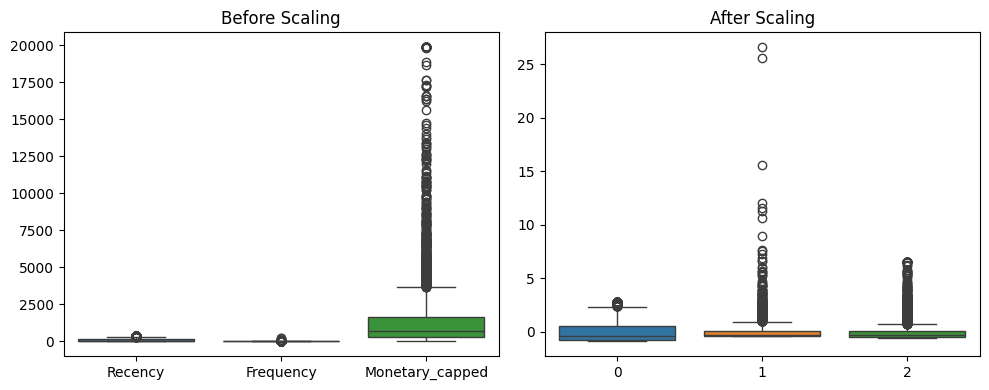

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm_for_model)

# Compare before vs after scaling
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=rfm_for_model, ax=axes[0])
axes[0].set_title("Before Scaling")
sns.boxplot(data=X, ax=axes[1])
axes[1].set_title("After Scaling")
plt.tight_layout()
plt.show()

# ==============================================================
# 7) Cluster Evaluation (Silhouette, CH, DBI)
# ==============================================================

### 📈 Cluster Evaluation
To validate clustering, we use **3 metrics**:

- **Silhouette Score** → how well customers fit within their cluster vs others.  
- **Calinski-Harabasz Index** → ratio of cluster separation vs cohesion. Higher = better.  
- **Davies-Bouldin Index** → average similarity between clusters. Lower = better.  

This ensures our chosen cluster number is not just arbitrary but also statistically sound.


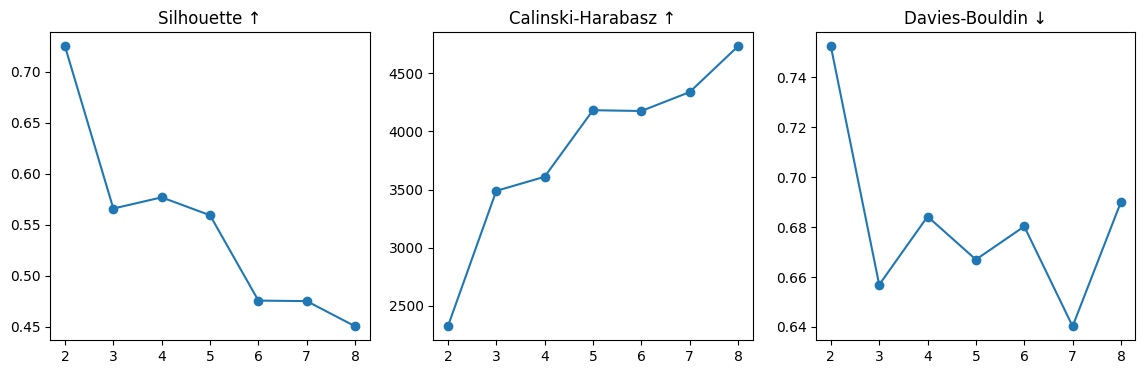

In [6]:
cluster_range = list(range(2,9))
sil_scores, ch_scores, dbi_scores, inertias = [], [], [], []

for k in cluster_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))
    ch_scores.append(calinski_harabasz_score(X, labels))
    dbi_scores.append(davies_bouldin_score(X, labels))
    inertias.append(km.inertia_)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(cluster_range, sil_scores, marker='o'); plt.title("Silhouette ↑")
plt.subplot(1,3,2)
plt.plot(cluster_range, ch_scores, marker='o'); plt.title("Calinski-Harabasz ↑")
plt.subplot(1,3,3)
plt.plot(cluster_range, dbi_scores, marker='o'); plt.title("Davies-Bouldin ↓")
plt.show()

# ==============================================================
# 8) Final KMeans Model
# ==============================================================

,Recency,Frequency,Monetary
Cluster,,,
0,44.14,3.58,1201.80
1,20.69,16.79,11750.69
2,248.35,1.54,456.66
3,5.77,77.45,76791.63


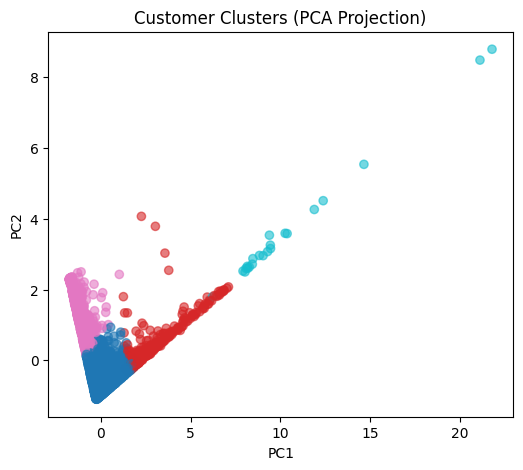

In [7]:
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=RANDOM_STATE)
rfm['Cluster'] = kmeans.fit_predict(X)

display(rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2))

# PCA for 2D visualization
pca = PCA(2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=rfm['Cluster'], cmap='tab10', alpha=0.6)
plt.title("Customer Clusters (PCA Projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# ==============================================================
# 9) Label Segments
# ==============================================================

In [8]:
cluster_stats = rfm.groupby('Cluster').agg(
    Recency_mean=('Recency','mean'),
    Frequency_mean=('Frequency','mean'),
    Monetary_mean=('Monetary','mean')
).reset_index()

# Scoring: low recency, high frequency & monetary
def min_max_norm(s): return (s - s.min()) / (s.max()-s.min()+1e-9)
score = (1-min_max_norm(cluster_stats['Recency_mean'])) + min_max_norm(cluster_stats['Frequency_mean']) + min_max_norm(cluster_stats['Monetary_mean'])
cluster_stats['Score'] = score

labels = ["High-Value Loyal","Potential Loyalist","At-Risk","Low-Value"]
if len(cluster_stats) > len(labels):
    labels += [f"Segment {i}" for i in range(len(labels), len(cluster_stats))]

cluster_stats = cluster_stats.sort_values('Score', ascending=False).reset_index(drop=True)
cluster_stats['Segment'] = labels[:len(cluster_stats)]
cluster_to_label = dict(zip(cluster_stats['Cluster'], cluster_stats['Segment']))

rfm['Segment'] = rfm['Cluster'].map(cluster_to_label)

display(cluster_stats)

,Cluster,Recency_mean,Frequency_mean,Monetary_mean,Score,Segment
0,3,5.772727,77.454545,76791.632727,3.000000e+00,High-Value Loyal
1,1,20.686567,16.791045,11750.688358,1.287389e+00,Potential Loyalist
2,0,44.141039,3.582245,1201.803086,8.785153e-01,At-Risk
3,2,248.345249,1.538100,456.655965,4.122480e-12,Low-Value


# ==============================================================
# 10) Insights & Visualizations
# ==============================================================

# 📊 Business Insights from Segmentation

## Segment Profiles
- **High-Value Loyal** → Recent, frequent, high spenders. Most profitable group.  
- **Potential Loyalist** → Recent or frequent buyers, growing potential.  
- **At-Risk** → Used to buy but haven’t returned recently. Need reactivation.  
- **Low-Value** → Rare, low-spending customers. Limited impact.  

---

## Segment-Level Averages (RFM Heatmap)
This heatmap shows the **average Recency, Frequency, and Monetary** for each segment.  

- Darker = higher values.  
- Helps quickly spot differences in customer behavior.

---

## Top Customers per Segment
Below table lists the **Top 10 customers by Monetary value** in each segment.  
These customers can be directly targeted for retention campaigns.

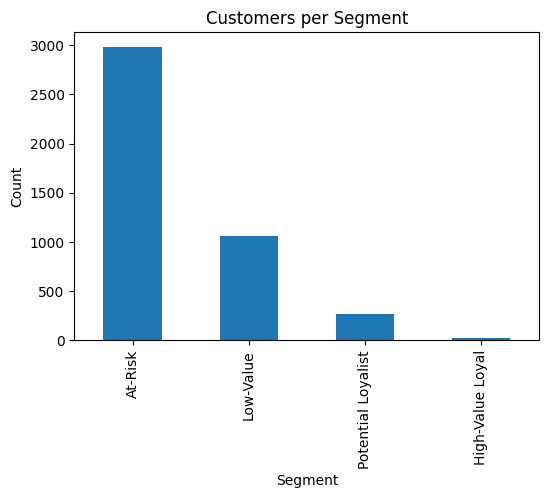

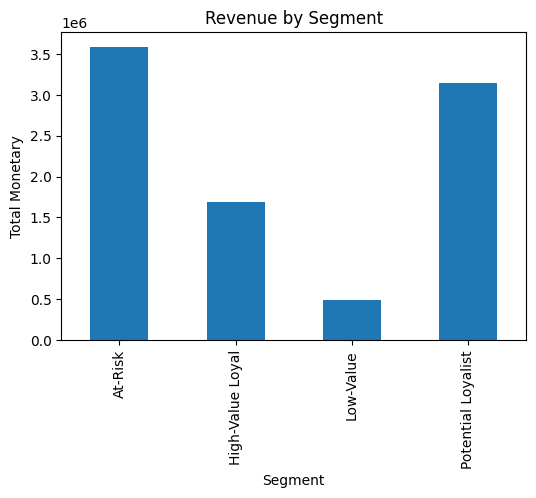

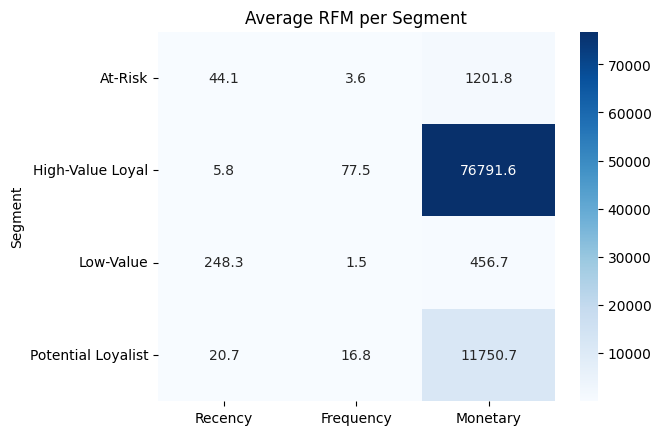

,CustomerID,Segment,Recency,Frequency,Monetary
2816,16182,At-Risk,72,4,6617.650
12,12359,At-Risk,58,4,6372.580
2773,16126,At-Risk,29,4,6287.770
10,12357,At-Risk,33,1,6207.670
729,13316,At-Risk,37,4,5977.730
1293,14101,At-Risk,74,6,5976.790
2228,15382,At-Risk,15,6,5955.710
3903,17686,At-Risk,7,7,5739.460
1255,14049,At-Risk,17,4,5681.720
154,12539,At-Risk,22,4,5568.350


In [9]:
# Segment counts
plt.figure(figsize=(6,4))
rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customers per Segment"); plt.ylabel("Count"); plt.show()

# Revenue contribution
plt.figure(figsize=(6,4))
rfm.groupby('Segment')['Monetary'].sum().plot(kind='bar')
plt.title("Revenue by Segment"); plt.ylabel("Total Monetary"); plt.show()

# Heatmap of avg RFM per segment
seg_means = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
sns.heatmap(seg_means, annot=True, fmt=".1f", cmap="Blues")
plt.title("Average RFM per Segment")
plt.show()

# Top 10 customers by Monetary per segment
top_customers = (rfm.reset_index()
                   .sort_values(['Segment','Monetary'], ascending=[True,False])
                   .groupby('Segment').head(10))
display(top_customers[['CustomerID','Segment','Recency','Frequency','Monetary']])

# ==============================================================
# 11) Recommendations
# ==============================================================

"""
📌 Segment Strategies

1. High-Value Loyal 💎
- Loyalty rewards, VIP programs
- Early access, exclusive offers

2. Potential Loyalist 🌱
- Upsell / cross-sell campaigns
- Personalized discounts to increase frequency

3. At-Risk ⚠️
- Win-back campaigns ("We miss you" emails, limited-time offers)
- Discounts to encourage return

4. Low-Value ❄️
- Broad, low-cost marketing (newsletters, social media)
- Do not overspend on retention

💡 Impact:
- Improved retention
- Reduced churn
- Higher lifetime value (CLV)
- Optimized marketing budget

# ==============================================================
# 12) Export Segmented Customers
# ==============================================================

In [10]:
out = rfm.reset_index()[['CustomerID','Recency','Frequency','Monetary','Cluster','Segment']]
out.to_csv(EXPORT_CSV, index=False)
print(f"✅ Exported {EXPORT_CSV}")

✅ Exported segmented_customers.csv
